In [1]:
import codecs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer

import classify
from sentiment import read_files

In [2]:
# load data csv
data_path = 'data/bills93-114.csv'
with codecs.open(data_path, 'r', encoding='utf-8',
                 errors='ignore') as f:
    df = pd.read_csv(f, sep=';')

In [32]:
# process data: add in derived columns
process_name = lambda s: s[0]+s.split()[0].lower()[1:]
df['NameFirstSimple'] = df['NameFirst'].map(process_name)
df['NameLastSimple'] = df['NameLast'].map(process_name)
df['NameFirstLast'] = df['NameFirstSimple']+' '+df['NameLastSimple']

In [66]:
def show_vc(vc):
    vc = dict(vc)
    lo, hi = min(vc.keys()), max(vc.keys())
    rng = list(range(lo, hi+1))
    val = [vc.get(k, 0) for k in rng]
    plt.plot(rng, val)
    plt.ylim(bottom=0)
    plt.show()

def make_distrib(l):
    l = np.array(l)
    return l / l.sum()

In [ ]:
num_vars = ['Cosponsr', 'Mult', 'MultNo']
target_var = 'PLaw'
aux_target_vars = ['PassH', 'PassS']


In [69]:
df[(df['PassH'] == True) & (df['PassS'] == True) & (df['Veto'] == True)]['PLaw'].mean()

0.1103202846975089

In [99]:
df.keys()

Index(['BillID', 'BillNum', 'BillType', 'Chamber', 'Cong', 'Cosponsr',
       'IntrDate', 'Mult', 'MultNo', 'PLaw', 'Private', 'Title', 'Veto',
       'Class', 'ComC', 'ComR', 'CumHServ', 'CumSServ', 'Delegate', 'District',
       'DW1', 'FrstConH', 'FrstConS', 'Gender', 'MemberID', 'MRef',
       'NameFirst', 'NameFull', 'NameLast', 'Party', 'PooleID', 'Postal',
       'State', 'URL', 'ChRef', 'RankRef', 'PassH', 'PassS', 'PLawDate',
       'PLawNum', 'ImpBill', 'SubChRef', 'SubRankRef', 'Majority', 'ReportH',
       'ReportS', 'Major', 'Minor'],
      dtype='object')

In [102]:
p = df['PLaw'].mean()

In [121]:
len(df[df['Gender'] == True]['NameFirstLast'].unique())

185

In [176]:
conf = 1.29
male_rate = df[(df['Cong'] > 110) & (df['Gender'] == False)]['PLaw'].mean()
female_rate = df[(df['Cong'] > 110) & (df['Gender'] == True)]['PLaw'].mean()
n_male = ((df['Cong'] > 110) & (df['Gender'] == False)).sum()
n_female = ((df['Cong'] > 110) & (df['Gender'] == True)).sum()
male_std = conf * np.sqrt(p * (1 - p) / n_male)
female_std = conf * np.sqrt(p * (1 - p) / n_female)
hi = (male_rate+male_std) / (female_rate-female_std)
lo = (male_rate-male_std) / (female_rate+female_std)
print(lo, hi)

1.0945942921384524 1.518853446270187


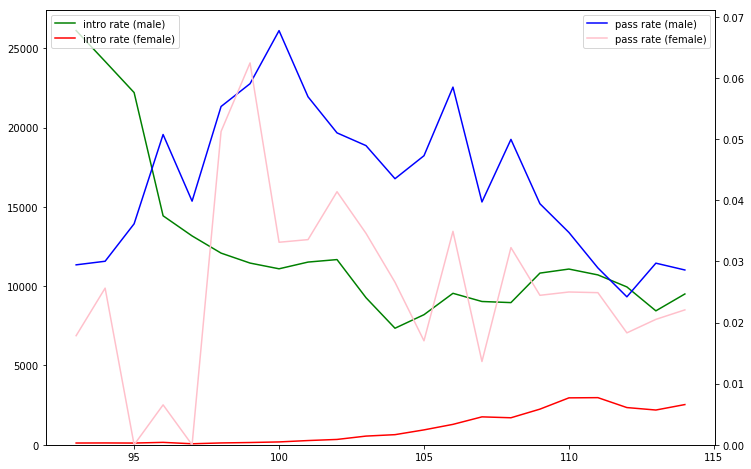

In [164]:
rates = []
congs = df['Cong'].unique()
rates = [df[df['Cong'] == c]['PLaw'].mean() for c in congs]
rates_male = [df[(df['Cong'] == c) & (df['Gender'] == False)]['PLaw'].mean() for c in congs]
rates_female = [df[(df['Cong'] == c) & (df['Gender'] == True)]['PLaw'].mean() for c in congs]

freqs = [(df['Cong'] == c).sum() for c in congs]
freqs_male = [((df['Cong'] == c) & (df['Gender'] == False)).sum() for c in congs]
freqs_female = [((df['Cong'] == c) & (df['Gender'] == True)).sum() for c in congs]

num_male = [len(df[(df['Cong'] == c) & (df['Gender'] == False)]['NameFirstLast'].unique()) for c in congs]
num_female = [len(df[(df['Cong'] == c) & (df['Gender'] == True)]['NameFirstLast'].unique()) for c in congs]

prop_female = np.array(freqs_female) / np.array(num_female)
prop_male = np.array(freqs_male) / np.array(num_male)

std_female = [1.95*np.sqrt(p*(1-p)/f) for f in freqs_female]

colors = ['green', 'blue', 'pink', 'red', 'orange', 'purple', 'brown']

fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.plot(congs, freqs_male, label='intro rate (male)', color=colors[0])
ax1.plot(congs, freqs_female, label='intro rate (female)', color=colors[3])
ax1.legend(loc='upper left')
ax1.set_ylim(bottom=0)

ax2 = ax1.twinx()
ax2.plot(congs, rates_male, label='pass rate (male)', color=colors[1])
ax2.plot(congs, rates_female, label='pass rate (female)', color=colors[2])
# ax2.plot(congs, std_female, label='1.95*std (female)', color=colors[4])
ax2.legend(loc='upper right')
ax2.set_ylim(bottom=0)

# ax3 = ax1.twinx()
# ax3.plot(congs, prop_male, label='rate per (male)', color=colors[6])
# ax3.plot(congs, prop_female, label='rate per (female)', color=colors[5])
# ax3.legend(loc='lower left')

plt.show()

In [104]:
perc_male = (df['Gender'] == False).mean()
pass_ratio = df[df['Gender'] == False]['PLaw'].mean() / df[df['Gender'] == True]['PLaw'].mean()
print('%.3f of bills are submitted by men. these are %.3f as likely to pass as female ones' % (perc_male, pass_ratio))

0.919 of bills are submitted by men. these are 1.732 as likely to pass as female ones


In [ ]:
df_at = lambda c: df[df['Cong'] == c]

rates = []
congs = df['Cong'].unique()
rates = np.array([df_at(c)['PLaw'].mean() for c in congs])
rates_h = [df_at(c)['PassH'].mean() for c in congs]
rates_s = [df_at(c)['PassS'].mean() for c in congs]
rates_or = np.array([(df_at(c)['PassS'] | df_at(c)['PassH']).mean() for c in congs])
rates_and = np.array([(df_at(c)['PassS'] & df_at(c)['PassH']).mean() for c in congs])
rates_veto = np.array([df_at(c)['Veto'].mean() for c in congs])

colors = ['green', 'blue', 'pink', 'red', 'orange', 'purple', 'brown']

fig, ax1 = plt.subplots(figsize=(12, 8))
# ax1.plot(congs, freqs_male, label='intro rate (male)', color=colors[0])
# ax1.plot(congs, freqs_female, label='intro rate (female)', color=colors[3])
ax1.plot(congs, rates, label='pass rate', color=colors[0])
# ax1.plot(congs, rates_h, label='rate house of reps', color=colors[5])
# ax1.plot(congs, rates_s, label='rate senate', color=colors[6])
ax1.plot(congs, rates_and, label='rate AND', color=colors[1])
ax1.plot(congs, rates_or, label='rate OR', color=colors[2])
# ax1.plot(congs, rate_stds, label='rate std', color=colors[3])
ax1.legend(loc='upper left')
ax1.set_ylim(bottom=0)

ax2 = ax1.twinx()
# ax2.plot(congs, 1 - rates / rates_or, label='disagreement fraction (1 - # passed / # either house passed)', color=colors[4])
ax2.plot(congs, rates_veto / rates_and, label='veto frac', color=colors[3])
ax2.legend(loc='upper right')
ax2.set_ylim(top=1)
ax2.set_ylim(bottom=0)

plt.show()

In [ ]:
df[(df['PassH'] == True) & (df['PassS'] == True) & (df['Veto'] == True)]['PLaw'].mean()

In [ ]:
def show_vc(vc):
    vc = dict(vc)
    lo, hi = min(vc.keys()), max(vc.keys())
    rng = list(range(lo, hi+1))
    val = [vc.get(k, 0) for k in rng]
    plt.plot(rng, val)
    plt.ylim(bottom=0)
    plt.show()

# Modern

In [1]:
# ## OPTION B: Split dev set by gender.
# bool_cols = ['Party', 'Majority']

# trnX, trnY = process_df(train_df, bool_cols=bool_cols)

# male_df = dev_df[dev_df['Gender'] == False]
# female_df = dev_df[dev_df['Gender'] == True]

# devX_male, devY_male = process_df(male_df, bool_cols=bool_cols)
# devX_female, devY_female = process_df(female_df, bool_cols=bool_cols)

# devX, devY = sp.vstack([devX_male, devX_female]), np.concatenate([devY_male, devY_female])

In [ ]:
true_ratio = devY_male.mean() / devY_female.mean()
pred_ratio = cls.predict_proba(devX_male)[:, 1].mean() / cls.predict_proba(devX_female)[:, 1].mean()
print('True ratio: %.3f; Pred ratio: %.3f (nM=%d, nF=%d)' %
      (true_ratio, pred_ratio, len(devY_male), len(devY_female)))